In [1]:
# !pip install dask 
# !pip install imblearn
# !pip install catboost
# !python -m pip install 'fsspec>=0.3.3'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

# from catboost import CatBoostClassifier

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(9,6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (9, 4))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [7]:
%%time

train = pd.read_csv('data/train_merged_pca.csv')
test = pd.read_csv('data/test_merged_pca.csv')


CPU times: user 4.6 s, sys: 492 ms, total: 5.09 s
Wall time: 5.65 s


In [8]:
train.head()

,id,vas_id,buy_time,target,252,component_0,component_1,component_2,component_3,component_4,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
0,2582523,2.0,1531083600,0.0,0.0,-0.379565,3.028142,-3.500370,1.187461,1.037129,...,1.002739,0.263111,-0.435263,1.549308,-1.782069,-1.105894,-0.891954,0.241378,0.041470,-0.847622
1,1292549,2.0,1531083600,0.0,0.0,-0.732555,-1.241620,0.808876,-1.112869,-0.056170,...,-0.160786,-0.395541,-0.883232,-0.790913,0.155308,-1.031596,1.128488,-0.054172,-0.432766,-0.587913
2,4053116,1.0,1531083600,0.0,1.0,-4.904805,1.398003,-1.793186,4.859256,2.093246,...,0.227615,-0.612525,0.268357,0.206455,-0.924363,-1.556419,-1.225303,0.336331,1.378801,-1.779163
3,4158361,2.0,1531083600,0.0,1.0,0.738585,-0.327294,-0.920619,-0.507506,-0.035862,...,0.920590,-0.710220,-1.096234,-0.298477,0.576943,-0.538938,0.229892,-0.132580,0.933606,0.867556
4,3754468,4.0,1531083600,0.0,0.0,2.087168,0.021381,2.561606,-0.447806,-0.265248,...,-1.033349,-0.867090,-0.569756,0.052730,-0.848584,2.657796,-2.327419,0.606161,-0.487402,0.261275


In [9]:
test.head()

,id,vas_id,buy_time,252,component_0,component_1,component_2,component_3,component_4,component_5,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
0,2905850,5.0,1546808400,0.0,-2.108865,2.008964,-0.680932,-0.645873,-0.252169,0.058302,...,-0.582579,0.332824,-0.258431,-0.570570,-0.481163,-0.818266,1.374948,-0.097509,0.395715,0.105542
1,31619,2.0,1546808400,0.0,0.187221,-0.783811,1.446463,-0.970002,0.073032,-0.281519,...,-0.774290,0.718145,-0.916015,0.629134,0.800355,-0.203236,0.084248,0.179651,0.163358,0.593177
2,1427271,6.0,1546808400,0.0,-3.459512,2.924535,-1.996942,1.149771,0.273366,-1.354597,...,0.241564,1.047118,1.576573,-1.005940,0.940569,-1.116288,-0.873351,0.800971,0.145993,1.473983
3,2162521,6.0,1546808400,0.0,-0.421286,-1.363834,1.143938,-1.366164,0.200698,-0.374600,...,0.315521,0.168451,0.166489,-0.734784,-0.499309,-0.123867,0.424443,0.042869,-0.159201,-0.530986
4,1529304,6.0,1546808400,1.0,-4.070811,-1.120186,1.827899,0.396192,-0.248577,0.608398,...,0.395898,-0.747956,-1.003190,1.532903,1.056886,0.202940,0.059298,-0.193865,0.658619,0.539136


In [10]:
train.describe()

,id,vas_id,buy_time,target,252,component_0,component_1,component_2,component_3,component_4,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
count,8.316530e+05,831653.000000,8.316530e+05,831653.000000,831653.000000,8.316530e+05,831653.000000,831653.000000,8.316530e+05,831653.000000,...,831653.000000,831653.000000,831653.000000,8.316530e+05,831653.000000,831653.000000,831653.000000,8.316530e+05,831653.000000,831653.000000
mean,2.158304e+06,2.686185,1.538937e+09,0.072369,0.258348,-2.973488e-07,-0.000002,-0.000003,-7.521257e-07,0.000002,...,-0.000006,0.000002,0.000003,-5.026830e-07,-0.000003,-0.000002,0.000001,-7.364982e-08,0.000002,-0.000002
std,1.257907e+06,1.952034,5.019053e+06,0.259098,2.095543,4.168477e+00,3.196697,2.754510,2.608547e+00,2.401133,...,1.257200,1.240602,1.232778,1.214146e+00,1.186233,1.182909,1.161123,1.155322e+00,1.144133,1.128467
min,2.000000e+00,1.000000,1.531084e+09,0.000000,0.000000,-1.883192e+01,-21.062065,-280.728360,-3.856438e+02,-436.865900,...,-153.830750,-134.932510,-92.144970,-8.327443e+01,-97.050280,-69.493126,-85.852130,-1.893339e+02,-175.377000,-112.403180
25%,1.067319e+06,1.000000,1.534108e+09,0.000000,0.000000,-2.851814e+00,-1.138848,-0.434562,-9.634501e-01,-0.327457,...,-0.354765,-0.324709,-0.538845,-5.906512e-01,-0.343207,-0.552736,-0.523569,-1.919642e-01,-0.292515,-0.416239
50%,2.144574e+06,2.000000,1.538341e+09,0.000000,0.000000,-4.483528e-01,-0.519214,0.651869,-2.572167e-01,-0.115142,...,0.003911,-0.020796,-0.068741,-5.544307e-02,0.028555,-0.051392,-0.014462,1.442842e-02,-0.056206,-0.036581
75%,3.244254e+06,4.000000,1.544389e+09,0.000000,1.000000,2.032402e+00,0.652993,1.321839,4.507245e-01,0.145756,...,0.383934,0.345321,0.398251,4.743933e-01,0.386430,0.476041,0.535573,2.207931e-01,0.224288,0.384766
max,4.362694e+06,9.000000,1.546204e+09,1.000000,1743.000000,3.033259e+02,2092.024000,746.168150,3.915152e+02,924.048460,...,220.645160,207.463320,173.070720,1.289207e+02,200.538480,148.055570,188.066570,2.635291e+02,219.694900,147.582720


In [11]:
train.target.value_counts(normalize=True)

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

In [12]:
test.head()

,id,vas_id,buy_time,252,component_0,component_1,component_2,component_3,component_4,component_5,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
0,2905850,5.0,1546808400,0.0,-2.108865,2.008964,-0.680932,-0.645873,-0.252169,0.058302,...,-0.582579,0.332824,-0.258431,-0.570570,-0.481163,-0.818266,1.374948,-0.097509,0.395715,0.105542
1,31619,2.0,1546808400,0.0,0.187221,-0.783811,1.446463,-0.970002,0.073032,-0.281519,...,-0.774290,0.718145,-0.916015,0.629134,0.800355,-0.203236,0.084248,0.179651,0.163358,0.593177
2,1427271,6.0,1546808400,0.0,-3.459512,2.924535,-1.996942,1.149771,0.273366,-1.354597,...,0.241564,1.047118,1.576573,-1.005940,0.940569,-1.116288,-0.873351,0.800971,0.145993,1.473983
3,2162521,6.0,1546808400,0.0,-0.421286,-1.363834,1.143938,-1.366164,0.200698,-0.374600,...,0.315521,0.168451,0.166489,-0.734784,-0.499309,-0.123867,0.424443,0.042869,-0.159201,-0.530986
4,1529304,6.0,1546808400,1.0,-4.070811,-1.120186,1.827899,0.396192,-0.248577,0.608398,...,0.395898,-0.747956,-1.003190,1.532903,1.056886,0.202940,0.059298,-0.193865,0.658619,0.539136


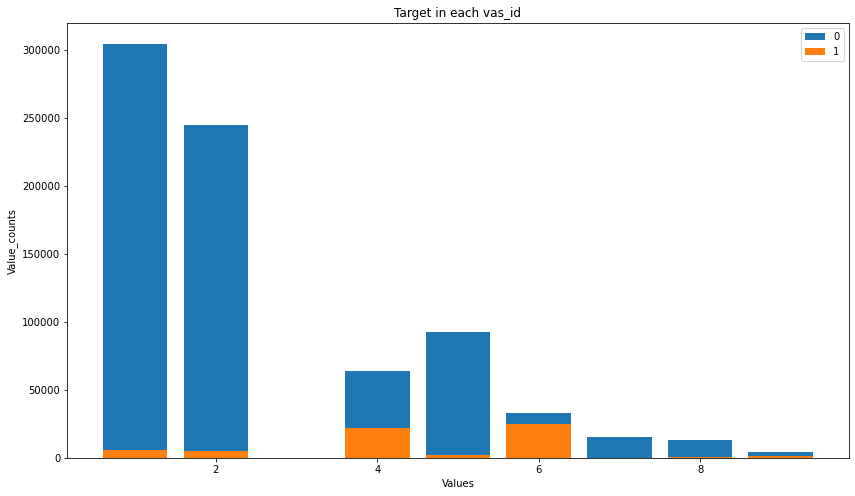

In [13]:
plt.figure(figsize=(14, 8))

vas_ids_1 = train.loc[train.target==1].vas_id.value_counts().sort_values()
vas_ids_0 = train.loc[train.target==0].vas_id.value_counts().sort_values()

plt.bar(vas_ids_0.index, vas_ids_0.values, label='0', )
plt.bar(vas_ids_1.index, vas_ids_1.values, label='1')

plt.title('Target in each vas_id')
plt.xlabel('Values')
plt.ylabel('Value_counts')
plt.legend()
plt.show()

### Работа с временным признаком

Переконвертируем колонку в привычный формат даты, чтобы было удобно с ней работать. Из колонки создадим признаки и по ним посмотрим на распределение целевой переменной

In [14]:
train['buy_time'] = pd.to_datetime(train['buy_time'], unit='s')
test['buy_time'] = pd.to_datetime(test['buy_time'], unit='s')
test.sample()

,id,vas_id,buy_time,252,component_0,component_1,component_2,component_3,component_4,component_5,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
63909,1300655,4.0,2019-01-20 21:00:00,0.0,7.740596,-2.349941,1.526961,-1.627545,0.271978,-1.282202,...,-0.101011,1.266119,-0.574156,0.617152,0.612842,-0.142437,0.686235,-0.048606,1.249401,1.4746


In [15]:
pd.DatetimeIndex(train['buy_time']).year.unique().values

array([2018])

In [16]:
# Посмотрим на количество уникальных значений года и часа
print(f"Год (train): {pd.DatetimeIndex(train['buy_time']).year.unique().values}", 
      f"Год (test): {pd.DatetimeIndex(test['buy_time']).year.unique().values}", 
      f"Час (train): {pd.DatetimeIndex(train['buy_time']).hour.unique().values}", 
      f"Час (test): {pd.DatetimeIndex(test['buy_time']).hour.unique().values}", sep='\n')


Год (train): [2018]
Год (test): [2019]
Час (train): [21]
Час (test): [21]


Видно, что наблюдения в обеих выборках принимают только одно значение, по-этому эти столбцы не дадут никакой информации для модели. Создадим колонки месяц и день и проанализируем значения

In [17]:
train['month'] = pd.DatetimeIndex(train['buy_time']).month
test['month'] = pd.DatetimeIndex(test['buy_time']).month

train['day'] = pd.DatetimeIndex(train['buy_time']).day
test['day'] = pd.DatetimeIndex(test['buy_time']).day

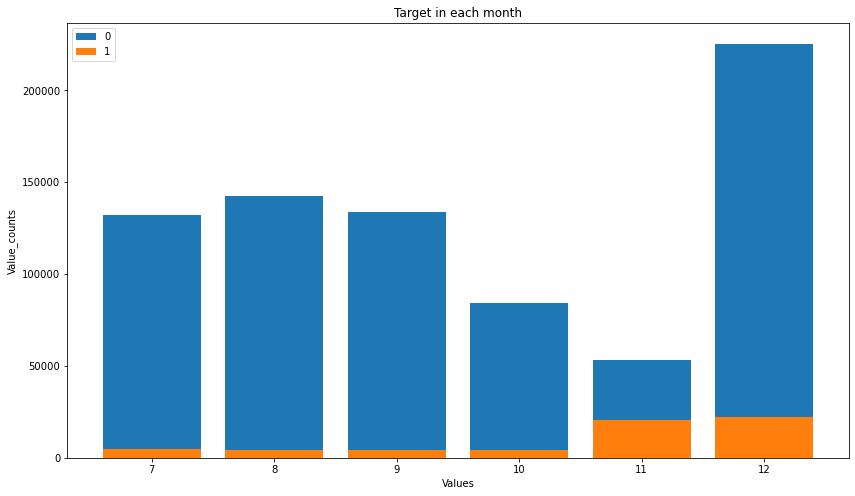

In [18]:
plt.figure(figsize=(14, 8))

months_1 = train.loc[train.target==1].month.value_counts().sort_values()
months_0 = train.loc[train.target==0].month.value_counts().sort_values()

plt.bar(months_0.index, months_0.values, label='0')
plt.bar(months_1.index, months_1.values, label='1')

plt.title('Target in each month')
plt.xlabel('Values')
plt.ylabel('Value_counts')
plt.legend()
plt.show()

In [19]:
for month in train.month.unique():
  print(f'For month # {month}')
  print(train.loc[train.month==month].target.value_counts(normalize=True))

For month # 7
0.0    0.965906
1.0    0.034094
Name: target, dtype: float64
For month # 8
0.0    0.971949
1.0    0.028051
Name: target, dtype: float64
For month # 9
0.0    0.969003
1.0    0.030997
Name: target, dtype: float64
For month # 10
0.0    0.950052
1.0    0.049948
Name: target, dtype: float64
For month # 11
0.0    0.721382
1.0    0.278618
Name: target, dtype: float64
For month # 12
0.0    0.910324
1.0    0.089676
Name: target, dtype: float64


Видно, что во всех месяцах, кроме 11 вероятность появления целевого класса  более-менее похожа. Посмотрим, как распределен таргет по дням

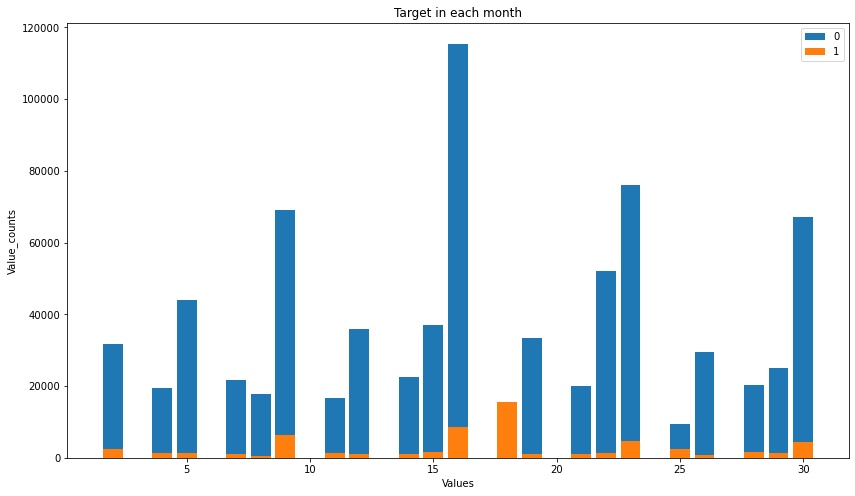

In [20]:
plt.figure(figsize=(14, 8))

days_1 = train.loc[train.target==1].day.value_counts().sort_values()
days_0 = train.loc[train.target==0].day.value_counts().sort_values()

plt.bar(days_0.index, days_0.values, label='0', )
plt.bar(days_1.index, days_1.values, label='1')

plt.title('Target in each month')
plt.xlabel('Values')
plt.ylabel('Value_counts')
plt.legend()
plt.show()

In [21]:
train.loc[train.day==18].target.value_counts()

1.0    15418
0.0     7497
Name: target, dtype: int64

In [22]:
test.loc[test.day==18]

,id,vas_id,buy_time,252,component_0,component_1,component_2,component_3,component_4,component_5,...,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49,month,day


18 числа в тесте нет, при этом в трейне наблюдается аномалия по таргету в этот день, посмотрим, в каком месяце наблюдались такие значения

In [23]:
train.loc[train.day==18].month.value_counts()

11    22915
Name: month, dtype: int64

Возможно, эта дата дает такое смещение в 11 месяце. Посмотрим на распределение таргета в 11 месяце без 18 числа

In [24]:
 train.loc[~(train.day==18) & (train.month==11)].target.value_counts(normalize=True)

0.0    0.899891
1.0    0.100109
Name: target, dtype: float64

теперь выглядит более адекватно (но все равно выбивается из картины предыдущих трех месяцев. Сначала попробуем обучить модель без 18.11). Посмотрим на распределение по дням в каждом месяце

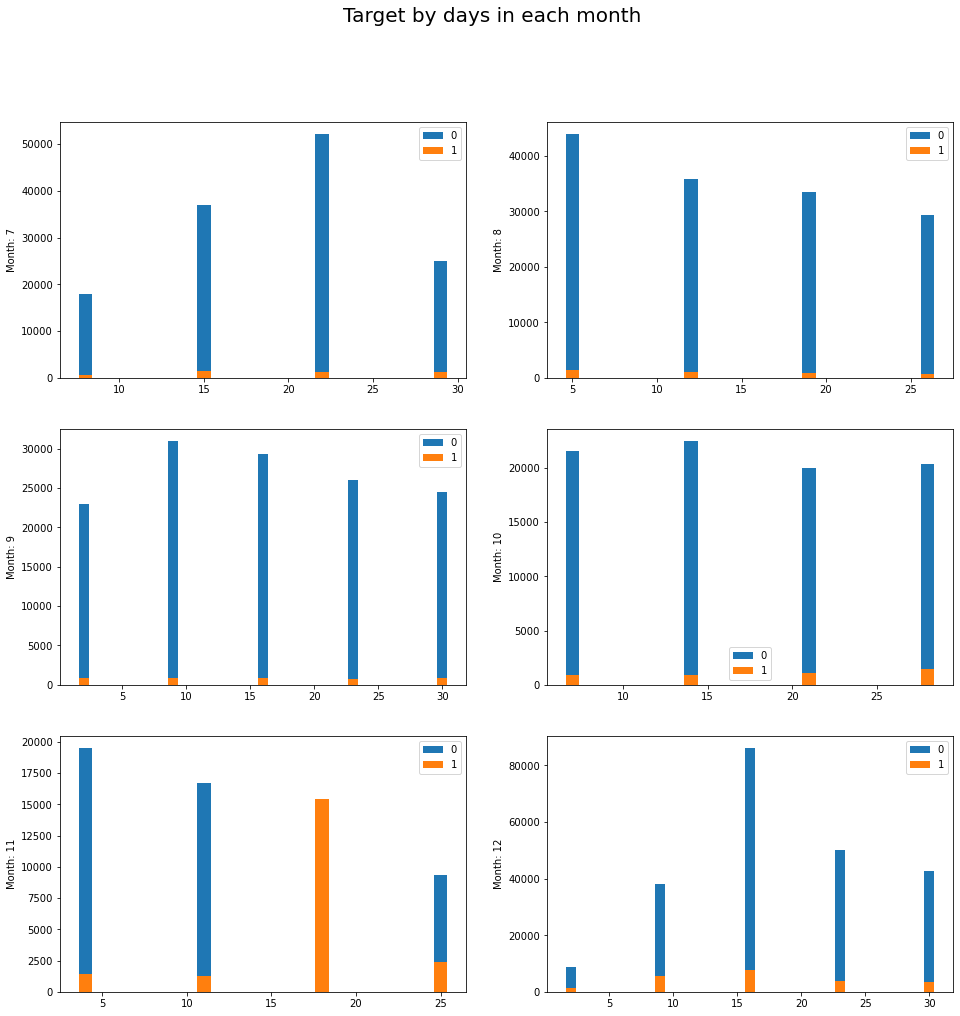

In [25]:
months = np.sort(train.month.unique())
fig=plt.figure(figsize=(16, 16))

plt.suptitle("Target by days in each month", size=20)
i=0
for month_ in months:
    
    days_1 = train.loc[(train.target==1) & (train.month==month_)].day.value_counts().sort_values()
    days_0 = train.loc[(train.target==0) & ((train.month==month_))].day.value_counts().sort_values()
    
    ax=plt.subplot(321+i)
    ax = plt.bar(days_0.index, days_0.values, label='0', )
    ax = plt.bar(days_1.index, days_1.values, label='1')

    ax = plt.ylabel(f'Month: {month_}')
    ax = plt.legend()
    i+=1  


В первых 4х месяцах распределение таргета более менее стабильное, возможно, лучше будет удалить 11 и 12 месяц (проверить)

In [26]:
# #Корелляция с  признаками

# TARGET = 'target'
# FEATURES = train.columns.drop(TARGET).tolist()

# corr_with_target = train[FEATURES + [TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)

# plt.figure(figsize=(16, 40))

# sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

# plt.title('Correlation with target variable')
# plt.show()

In [27]:
# удалим 18 день (аномальные значения. Может акция какая-то, может что-то бесплатно подключали, но это не тот случай, который нас интересует, не будем на нем обучаться) 
train = train.loc[~(train.day==18)]

# train = train.loc[~(train.month.isin([11, 12]))] - хуже метрика

In [28]:
# df_train = train.loc[~train['month'].isin([12])]
# df_valid = train.loc[train['month'].isin([12])]

# df_train.target.value_counts(normalize=True), df_valid.target.value_counts(normalize=True)

Не очень хорошее распределение получилось на train и valid, по-этому переразобьем стратифицированно с помощью train_test_split

### Разбиение на train и test

In [29]:
df_train, df_valid = train_test_split(train, 
                                      shuffle=True, 
                                      test_size=0.3, 
                                      stratify=train['target'], 
                                      random_state=42)

In [30]:
df_train.target.value_counts(normalize=True)

0.0    0.944644
1.0    0.055356
Name: target, dtype: float64

In [31]:
df_valid.target.value_counts(normalize=True)

0.0    0.944646
1.0    0.055354
Name: target, dtype: float64

In [32]:
# добавим в качестве признака вероятность подключения услуг
# buy_proba = df_train.groupby('vas_id')['target'].apply(lambda x: x.sum() / x.count()).reset_index().rename(columns={'vas_id':'vas_id', 'target': 'probability'})

values = df_train.groupby(['vas_id', 'target'])['id'].size().reset_index()
values['probability'] = values['id'] / len(df_train)
values.drop(columns='id', inplace=True)
values


,vas_id,target,probability
0,1.0,0.0,0.372996
1,1.0,1.0,0.003508
2,2.0,0.0,0.300158
3,2.0,1.0,0.002272
4,4.0,0.0,0.077366
5,4.0,1.0,0.019916
6,5.0,0.0,0.113350
7,5.0,1.0,0.000618
8,6.0,0.0,0.040956
9,6.0,1.0,0.028770


In [33]:
def add_proba(train, test):
  # fit
  values = train.groupby(['vas_id', 'target'])['id'].size().reset_index()
  values['probability'] = values['id'] / len(df_train)
  values.drop(columns=['id', 'target'], inplace=True)

  
  train = train.merge(values, on=['vas_id'], how='left')
  # transform
  test = test.merge(values, on=['vas_id'], how='left')
  
  return train, test

In [34]:
train, test = add_proba(train, test)
test.tail(3)

,id,vas_id,buy_time,252,component_0,component_1,component_2,component_3,component_4,component_5,...,component_43,component_44,component_45,component_46,component_47,component_48,component_49,month,day,probability
142459,1447357,6.0,2019-01-20 21:00:00,0.0,1.051441,-2.085514,2.086823,-1.953215,0.114580,-0.682766,...,1.320252,0.882394,0.499117,-1.136313,-0.386444,-0.010193,0.508425,1,20,0.041016
142460,988236,2.0,2019-01-20 21:00:00,0.0,4.329867,-2.173344,1.416670,-2.705303,0.492999,-1.291205,...,0.459323,-0.219589,1.259391,0.248230,-0.307883,0.014105,-0.347168,1,20,0.429020
142461,988236,2.0,2019-01-20 21:00:00,0.0,4.329867,-2.173344,1.416670,-2.705303,0.492999,-1.291205,...,0.459323,-0.219589,1.259391,0.248230,-0.307883,0.014105,-0.347168,1,20,0.003328


In [35]:
train.head(2)

,id,vas_id,buy_time,target,252,component_0,component_1,component_2,component_3,component_4,...,component_43,component_44,component_45,component_46,component_47,component_48,component_49,month,day,probability
0,2582523,2.0,2018-07-08 21:00:00,0.0,0.0,-0.379565,3.028142,-3.50037,1.187461,1.037129,...,1.549308,-1.782069,-1.105894,-0.891954,0.241378,0.04147,-0.847622,7,8,0.429020
1,2582523,2.0,2018-07-08 21:00:00,0.0,0.0,-0.379565,3.028142,-3.50037,1.187461,1.037129,...,1.549308,-1.782069,-1.105894,-0.891954,0.241378,0.04147,-0.847622,7,8,0.003328


In [36]:
df_train = df_train.merge(values, on=['vas_id', 'target'], how='left')
df_valid = df_valid.merge(values, on=['vas_id', 'target'], how='left')

df_train.head()

,id,vas_id,buy_time,target,252,component_0,component_1,component_2,component_3,component_4,...,component_43,component_44,component_45,component_46,component_47,component_48,component_49,month,day,probability
0,1610623,4.0,2018-09-09 21:00:00,0.0,0.0,-0.075345,-0.795470,-0.537617,-1.132301,0.315816,...,0.783119,1.516354,-1.442360,0.934877,-0.121024,2.058582,2.906931,9,9,0.077366
1,57357,5.0,2018-12-30 21:00:00,0.0,0.0,-1.242302,-0.826880,0.232477,-0.602526,-0.003291,...,-0.104100,-0.108473,-0.000231,0.624520,-0.170450,0.255103,0.395633,12,30,0.113350
2,2041775,2.0,2018-08-05 21:00:00,0.0,0.0,-2.790545,-0.165194,-0.225071,-0.573385,-0.021864,...,1.392191,-0.357403,1.326931,-0.537469,0.502586,0.343794,-0.359280,8,5,0.300158
3,3226133,2.0,2018-08-19 21:00:00,0.0,0.0,3.046451,5.843786,6.547472,1.551477,44.838320,...,0.861064,-12.592044,2.524875,1.868788,-38.800390,-21.884132,1.205023,8,19,0.300158
4,4073569,1.0,2018-10-07 21:00:00,0.0,0.0,-1.112723,-1.200500,2.008357,-0.441132,-0.150480,...,0.361085,0.208214,0.788043,-1.688426,2.374644,5.481839,-0.937705,10,7,0.372996


In [37]:
train.probability.isnull().sum(), test.probability.isnull().sum()
# нулей нет

(0, 0)

In [38]:
# Кластеризация клиентов

### Балансировка целевой переменной

In [39]:
def balance_df_by_target(df, target_name):
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)
            
    return df.sample(frac=1) 

In [40]:
disbalance = df_train.target.value_counts()[0] / df_train.target.value_counts()[1]
disbalance

17.06484140659902

In [41]:
columns = list(set(df_train.columns) - {'id', 'vas_id', 'buy_time', 'target', '252', 'month', 'day'})
columns

['component_38',
 'component_17',
 'component_11',
 'component_26',
 'component_30',
 'component_19',
 'component_31',
 'component_8',
 'component_6',
 'component_18',
 'component_2',
 'component_13',
 'component_46',
 'component_21',
 'component_0',
 'component_48',
 'component_45',
 'component_28',
 'probability',
 'component_32',
 'component_35',
 'component_36',
 'component_14',
 'component_44',
 'component_37',
 'component_43',
 'component_16',
 'component_40',
 'component_22',
 'component_49',
 'component_23',
 'component_41',
 'component_5',
 'component_4',
 'component_1',
 'component_15',
 'component_3',
 'component_27',
 'component_7',
 'component_9',
 'component_39',
 'component_42',
 'component_24',
 'component_20',
 'component_47',
 'component_12',
 'component_34',
 'component_33',
 'component_29',
 'component_10',
 'component_25']

In [42]:
df_train_balanced = balance_df_by_target(df_train, 'target')
    
df_train_balanced['target'].value_counts()

0.0    534778
1.0    532746
Name: target, dtype: int64

In [43]:
# для всего датасета

train_balanced = balance_df_by_target(train, 'target')
    
train_balanced['target'].value_counts()

0.0    1527940
1.0    1522112
Name: target, dtype: int64

In [44]:
# %%time
# from imblearn.under_sampling import TomekLinks

# X_train = train.drop(columns=['id', 'target', 'buy_time', 'month', 'day'])
# y_train = train.target 

# tl = TomekLinks()
# X_train_balanced, y_train_balanced = tl.fit_resample(X_train, y_train)

# y_train_balanced.value_counts()

In [45]:
X_train = df_train_balanced[columns]
y_train = df_train_balanced.target

X_test = df_valid[columns]
y_test = df_valid.target

In [46]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1067524, 51), (1067524,), (242622, 51), (242622,))

### Построение базовых моделей

Была выбрана базовая модель логистической регрессии, так как на наших данных она отрабатывает быстрее всех остальных

In [47]:
# базовая модель LogisticRegression()
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, n_jobs=-1)
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

/Users/catherine/.conda/envs/workspace-3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.96    534778
         1.0       0.92      1.00      0.96    532746

    accuracy                           0.96   1067524
   macro avg       0.96      0.96      0.96   1067524
weighted avg       0.96      0.96      0.96   1067524

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.96    229192
         1.0       0.41      1.00      0.58     13430

    accuracy                           0.92    242622
   macro avg       0.70      0.96      0.77    242622
weighted avg       0.97      0.92      0.93    242622

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     209563  19629
1.0          5  13425


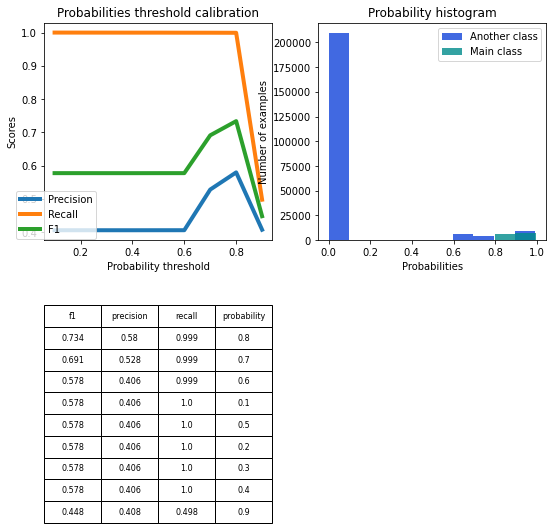

In [48]:
# подберем отсечку по вероятности 

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict_proba(X_test)


show_proba_calibration_plots(y_test_pred[:,1], y_test)

In [49]:
y_test_pred = np.where(y_test_pred[:, 1] > 0.8, 1, 0)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.96    534778
         1.0       0.92      1.00      0.96    532746

    accuracy                           0.96   1067524
   macro avg       0.96      0.96      0.96   1067524
weighted avg       0.96      0.96      0.96   1067524

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98    229192
         1.0       0.58      1.00      0.73     13430

    accuracy                           0.96    242622
   macro avg       0.79      0.98      0.86    242622
weighted avg       0.98      0.96      0.96    242622

CONFUSION MATRIX

col_0        0      1
target               
0.0     219470   9722
1.0         11  13419


### Кросс-валидация

In [50]:
cv_score = cross_val_score(
    lr,
    X_train[columns],
    y_train,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

/Users/catherine/.conda/envs/workspace-3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/catherine/.conda/envs/workspace-3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

array([0.9588384 , 0.95917936, 0.95911028, 0.95844634, 0.95873487])

Сделаем финальное предсказание на всем датасете

In [51]:
X_train_full = train_balanced[columns]
y_train_full = train_balanced.target

X_test_full = test[columns]

lr = LogisticRegression(random_state=42, n_jobs=-1)

lr.fit(X_train_full, y_train_full)
y_test_pred_full = lr.predict_proba(X_test_full)
y_test_pred_full = np.where(y_test_pred_full[:, 1] > 0.8, 1, 0)

pickle.dump(
    lr, open("model.pkl", "wb")
)

In [52]:
test

,id,vas_id,buy_time,252,component_0,component_1,component_2,component_3,component_4,component_5,...,component_43,component_44,component_45,component_46,component_47,component_48,component_49,month,day,probability
0,2905850,5.0,2019-01-06 21:00:00,0.0,-2.108865,2.008964,-0.680932,-0.645873,-0.252169,0.058302,...,-0.570570,-0.481163,-0.818266,1.374948,-0.097509,0.395715,0.105542,1,6,0.161841
1,2905850,5.0,2019-01-06 21:00:00,0.0,-2.108865,2.008964,-0.680932,-0.645873,-0.252169,0.058302,...,-0.570570,-0.481163,-0.818266,1.374948,-0.097509,0.395715,0.105542,1,6,0.000851
2,31619,2.0,2019-01-06 21:00:00,0.0,0.187221,-0.783811,1.446463,-0.970002,0.073032,-0.281519,...,0.629134,0.800355,-0.203236,0.084248,0.179651,0.163358,0.593177,1,6,0.429020
3,31619,2.0,2019-01-06 21:00:00,0.0,0.187221,-0.783811,1.446463,-0.970002,0.073032,-0.281519,...,0.629134,0.800355,-0.203236,0.084248,0.179651,0.163358,0.593177,1,6,0.003328
4,1427271,6.0,2019-01-06 21:00:00,0.0,-3.459512,2.924535,-1.996942,1.149771,0.273366,-1.354597,...,-1.005940,0.940569,-1.116288,-0.873351,0.800971,0.145993,1.473983,1,6,0.058465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142457,3145390,2.0,2019-01-20 21:00:00,0.0,3.061384,-2.295868,1.820947,-1.132860,-0.061771,-0.156534,...,0.507166,0.538925,-0.000148,-0.478881,0.021350,-0.016971,0.163567,1,20,0.003328
142458,1447357,6.0,2019-01-20 21:00:00,0.0,1.051441,-2.085514,2.086823,-1.953215,0.114580,-0.682766,...,1.320252,0.882394,0.499117,-1.136313,-0.386444,-0.010193,0.508425,1,20,0.058465
142459,1447357,6.0,2019-01-20 21:00:00,0.0,1.051441,-2.085514,2.086823,-1.953215,0.114580,-0.682766,...,1.320252,0.882394,0.499117,-1.136313,-0.386444,-0.010193,0.508425,1,20,0.041016
142460,988236,2.0,2019-01-20 21:00:00,0.0,4.329867,-2.173344,1.416670,-2.705303,0.492999,-1.291205,...,0.459323,-0.219589,1.259391,0.248230,-0.307883,0.014105,-0.347168,1,20,0.429020


In [80]:
test[['id', 'vas_id', 'buy_time']].head(2)

,id,vas_id,buy_time
0,2905850,5.0,2019-01-06 21:00:00
1,2905850,5.0,2019-01-06 21:00:00


In [54]:
test = test[['id', 'vas_id', 'buy_time']]
test['target'] = 0
test['target'] = y_test_pred_full
test.to_csv('Sokolova_predictions.csv', index=False, encoding='utf-8', sep=',')
test.head(10)

/var/folders/s5/6yjf0_gx61g9wqrz0b0sxrxc0000gn/T/ipykernel_45811/2290418110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['target'] = 0
/var/folders/s5/6yjf0_gx61g9wqrz0b0sxrxc0000gn/T/ipykernel_45811/2290418110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['target'] = y_test_pred_full


,id,vas_id,buy_time,target
0,2905850,5.0,2019-01-06 21:00:00,0
1,2905850,5.0,2019-01-06 21:00:00,0
2,31619,2.0,2019-01-06 21:00:00,0
3,31619,2.0,2019-01-06 21:00:00,0
4,1427271,6.0,2019-01-06 21:00:00,0
5,1427271,6.0,2019-01-06 21:00:00,0
6,2162521,6.0,2019-01-06 21:00:00,0
7,2162521,6.0,2019-01-06 21:00:00,0
8,1529304,6.0,2019-01-06 21:00:00,0
9,1529304,6.0,2019-01-06 21:00:00,0


In [55]:
# # базовая модель RandomForestClassifier
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(random_state=42, n_jobs=-1)
# rf.fit(X_train, y_train)

# y_train_pred = rf.predict(X_train)
# y_test_pred = rf.predict(X_test)


# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [56]:
# %%time
# from lightgbm import LGBMClassifier

# model_lgbm = LGBMClassifier(random_state=21, 
#                             n_estimators=100)
# model_lgbm.fit(X_train, y_train)

# y_train_pred = model_lgbm.predict(X_train)
# y_test_pred = model_lgbm.predict(X_test)


# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [57]:
# %%time
# # базовая модель Catboost
# catb = CatBoostClassifier(silent=True,
#                           random_state=21)
# catb.fit(X_train, y_train)

# y_train_pred = catb.predict(X_train)
# y_test_pred = catb.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [58]:
# %%time

# catb = CatBoostClassifier(silent=True,
#                           learning_rate=0.01, 
# #                           class_weights=[1, disbalance],
#                           max_depth=4,
#                           iterations=50,                        
#                           random_state=21)

# catb.fit(X_train, y_train)

# y_train_pred = catb.predict(X_train)
# y_test_pred = catb.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [59]:
# model_catb = CatBoostClassifier(silent=True, random_state=21,
#                                      eval_metric='F1',
#                                      early_stopping_rounds=30,
#                                      use_best_model=True,
#                                      custom_metric=['Precision', 'Recall']
#                                     )

# model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

In [60]:
# model_catb.best_score_

In [61]:
# evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

In [62]:
# frozen_params = {
#      'silent':True,
#      'random_state':21,
#      'eval_metric':'F1',
#      'early_stopping_rounds':30
# }

# model_catb = CatBoostClassifier(**frozen_params)

In [63]:
# params = {'iterations':[50, 200, 500, 700, 1500],
#           'learning_rate':[0.01, 0.005, 0.03],
#           'max_depth':[3, 4, 5, 6, 7, 8]}

In [64]:
# %%time

# cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

# grid_search = model_catb.grid_search(params, X_train, y_train, cv=cv, stratified=True, plot=True, refit=True)

In [65]:
# grid_search

In [66]:
# model_catb = CatBoostClassifier(**frozen_params, iterations=50, learning_rate=0.01, max_depth=8)

# model_catb.fit(X_train, y_train)

# y_train_pred = model_catb.predict(X_train)
# y_test_pred = model_catb.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [67]:
# y_test_pred = model_catb.predict_proba(X_test)

# show_proba_calibration_plots(y_test_pred[:,1], y_test)
# # get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [68]:
# y_test_pred = model_catb.predict_proba(X_test)
# y_test_pred = np.where(y_test_pred[:, 1] > 0.65, 1, 0)
# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [69]:
# pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

In [70]:
# уберу еще 12 месяц

In [71]:
# train = train.loc[~(train.month.isin([11, 12]))]
# train.month.unique()

# df_train, df_valid = train_test_split(train, 
#                                       shuffle=True, 
#                                       test_size=0.3, 
#                                       stratify=train['target'], 
#                                       random_state=42)

In [72]:
# df_train.target.value_counts(normalize=True)

In [73]:
# df_train_balanced = balance_df_by_target(df_train, 'target')
    
# df_train_balanced['target'].value_counts()

# X_train = df_train_balanced.drop(columns=['id', 'target', 'time', 'buy_time', 'month', 'day'])
# y_train = df_train_balanced.target

# X_test = df_valid.drop(columns=['id', 'target', 'time', 'buy_time', 'month', 'day'])
# y_test = df_valid.target

In [74]:
# frozen_params = {
#      'silent':True,
#      'random_state':21,
#      'eval_metric':'F1',
#      'early_stopping_rounds':30
# }

# model_catb = CatBoostClassifier(**frozen_params, iterations=100, learning_rate=0.01, max_depth=8)

# model_catb.fit(X_train, y_train)

# y_train_pred = model_catb.predict(X_train)
# y_test_pred = model_catb.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

### Модель без target-encoding

In [ ]:
# columns = list(set(df_train.columns) - {'id', 'vas_id', 'buy_time', 'target', '252', 'month', 'day', 'probability'})

# X_train = df_train_balanced[columns]
# y_train = df_train_balanced.target

# X_test = df_valid[columns]
# y_test = df_valid.target

# X_train.columns

In [ ]:
# # базовая модель RandomForestClassifier
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(random_state=42, n_jobs=-1)
# rf.fit(X_train, y_train)

# y_train_pred = rf.predict(X_train)
# y_test_pred = rf.predict(X_test)


# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

### Построим отдельную модель на каждую услугу

In [ ]:
# [2., 1., 4., 9., 6., 5., 8., 7.]

# услуга №1
train_1 = train.loc[train.vas_id == 1]
# услуга №2
train_2 = train.loc[train.vas_id == 2]
# услуга №4
train_4 = train.loc[train.vas_id == 4]
# услуга №5
train_5 = train.loc[train.vas_id == 5]
# услуга №6
train_6 = train.loc[train.vas_id == 6]
# услуга №7
train_7 = train.loc[train.vas_id == 7]
# услуга №8
train_8 = train.loc[train.vas_id == 8]
# услуга №9
train_9 = train.loc[train.vas_id == 9]

### 1 услуга

In [ ]:
train_1.head(3)

In [ ]:
train_1.target.value_counts(normalize=True)

In [ ]:
train_1.shape

In [ ]:
train_1.target.value_counts()

In [ ]:
# df_train, df_valid = train_test_split(train_1,
#                                       shuffle=True,
#                                       test_size=0.3,
#                                       stratify=train['target'],
#                                       random_state=42)
#
# df_train_balanced = balance_df_by_target(df_train, 'target')
#
# df_train_balanced['target'].value_counts()


In [ ]:
# X_train = df_train_balanced.drop(columns=['id', 'target', 'time', 'buy_time', 'month', 'day', 'vas_id'])
# y_train = df_train_balanced.target
#
# X_test = df_valid.drop(columns=['id', 'target', 'time', 'buy_time', 'month', 'day', 'vas_id'])
# y_test = df_valid.target

In [ ]:
# frozen_params = {
#      'silent':True,
#      'random_state':21,
#      'eval_metric':'F1',
#      'early_stopping_rounds':30
# }
#
# model_catb = CatBoostClassifier(**frozen_params, iterations=50, learning_rate=0.01, max_depth=8)
#
# model_catb.fit(X_train, y_train)
#
# y_train_pred = model_catb.predict(X_train)
# y_test_pred = model_catb.predict_proba(X_test)
#
# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
# show_learning_curve_plot(model_catb, X_train, y_train)